In [3]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
import yfinance as yf
import pandas as pd

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Retrieve data from Quandl

Don't bother with this step if the data's already saved from the Pickle below.

In [5]:
# import quandl
# quandl.ApiConfig.api_key = "Rxh8s4fTVLLS1vezj3R4"
# apl_stock=quandl.get('WIKI/AAPL', start_date="2001-01-01", end_date="2020-08-20", )
# msf_stock=quandl.get('WIKI/MSFT', start_date="2001-01-01", end_date="2020-08-20")
# apl_open = apl_stock["Open"].values
# apl_close = apl_stock["Close"].values
# msf_open = msf_stock["Open"].values
# msf_close = msf_stock["Close"].values

In [6]:
tickers = ['AAPL',
    'MSFT',
    'META',
    'AMZN',
    'NVDA',
    'GOOGL',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'HSY']

stocks = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    history = stock.history(period='10y')
    if not history.empty:
        open = history['Open'].values
        close = history['Close'].values
    stocks[ticker] = [history, open, close]


In [7]:
history = stock.history(period='5d')
print(history['Open'])

Date
2024-04-11 00:00:00-04:00    192.369995
2024-04-12 00:00:00-04:00    189.000000
2024-04-15 00:00:00-04:00    185.190002
2024-04-16 00:00:00-04:00    183.139999
2024-04-17 00:00:00-04:00    184.279999
Name: Open, dtype: float64


## Examine the data

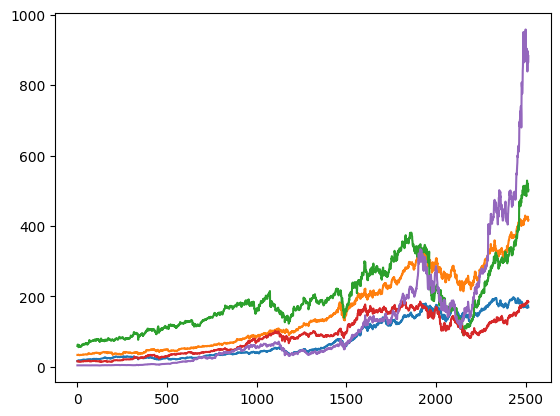

In [8]:
for ticker in tickers[:5]:
    plt.plot(range(0, len(stocks[ticker][1])), stocks[ticker][1])

## Oof! What's happened?

Turns out that on 9 June 2014, AAPL stock was split in the ratio of 1:7. So, I'll divide everything before element 108 in the stock array by 7 to correct for this.

## Looks better, now remove the general upwards trend.

Now I'm going to de-trend the data. Otherwise MSFT and AAPL are on completely different scales and we could hardly expect the AI to learn how to trade apples and oranges together. Additionally, we want the AI to learn the fundamentals of the stock signal - buy if it's going to rise. If we didn't remove the trend, maybe it'd only learn to buy at the start and hold til the end since a general upwards trend happens.

SciPy's signal processing module has a function that fits a linear least-squares model to the data and subtracts it for us.

In [9]:
from scipy import signal

In [10]:
for ticker in tickers:
    corrected_open = signal.detrend(stocks[ticker][1])
    min = corrected_open.min()
    if min <= 0:
        corrected_open += abs(min) + 0.01
    corrected_close = signal.detrend(stocks[ticker][2])
    min = corrected_close.min()
    if min <= 0:
        corrected_close += abs(min) + 0.01
    stocks[ticker].append(corrected_open)
    stocks[ticker].append(corrected_close)

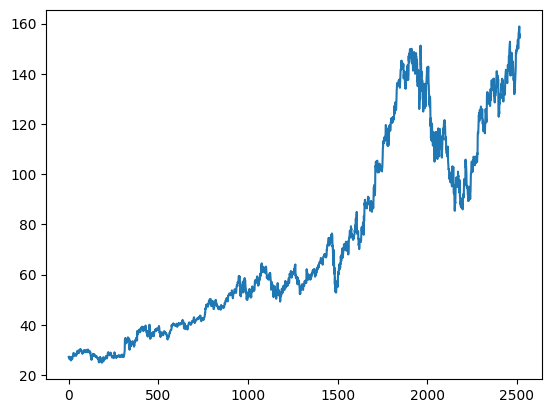

In [11]:
plt.plot(range(0,len(stocks[tickers[5]][1])), stocks[tickers[5]][1])

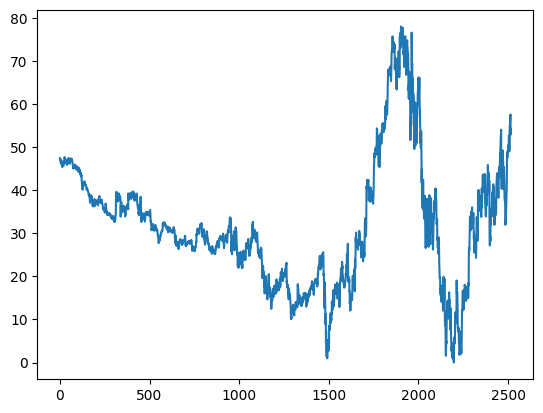

In [12]:
plt.plot(range(0,len(stocks[tickers[5]][3])), stocks[tickers[5]][3])

In [13]:
# plt.plot(range(0,len(apl_open)), apl_open)

# Build the environment

* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee

In [14]:
state = torch.FloatTensor(torch.zeros(8)).cuda()
stock_history = stock.history(period='10y')
state[3:8] = torch.tensor(stock_history["Open"].values[-5:])
print(stock_history["Open"].values.shape)

(2516,)


In [38]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=1000, max_stride=20, series_length=2500, starting_point=5, randomize_cash_std=0, \
                 starting_shares_mean=0, randomize_shares_std=0.5, inaction_penalty=0):
        ticker = np.random.choice(tickers)
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(21)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)

        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        self.stock = yf.Ticker('MSFT')
        self.stock_history = stock.history(period='10y')
        
        # self.state[0] = 0
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = self.starting_portfolio_value
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])
        self.max_stride = max_stride
        if self.max_stride == 1:
            self.stride = 1
        else:
            self.stride = np.random.choice(np.arange(1,self.max_stride))
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * stock_history["Open"].values[-1]) + self.state[1]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [stock_history["Open"].values[step], stock_history["Open"].values[step]]
    
    def step(self, action):
        msg = None
        if action == 0:  # Hold
            reward = 0
            msg = {'msg' : 'hold'}
        elif action == 1:  # Buy
            price = self.stock_history["Close"].values[self.cur_timestep]
            if price > self.state[1]:
                # reward = -self.state[2]
                reward = -10
                self.done = True
                msg = {'msg' : 'overdraw'}
            else:
                reward =  price - self.stock_history["Open"].values[self.cur_timestep]
                self.state[0] += 1  # Adjust shares
                self.state[1] -= self.stock_history["Open"].values[self.cur_timestep]  # Deduct cash
                msg = {'msg' : 'buy'}
        elif action == 2:  # Sell
            price = self.stock_history["Open"].values[self.cur_timestep]
            if self.state[0] > 0:
                reward = price - self.stock_history["Close"].values[self.cur_timestep]
                self.state[0] -= 1  # Adjust shares
                self.state[1] += self.stock_history["Open"].values[self.cur_timestep]  # Add cash
                msg = {'msg' : 'sell'}
            else:
                # reward = -self.state[2]
                reward = -10
                self.done = True
                msg = {'msg': 'oversell'}
        
        # Update portfolio value
        portfolio_val = self.portfolio_value()
        
        # Move to the next time step
        self.cur_timestep += self.stride
        
        # Check if episode is done
        if self.cur_timestep >= self.series_length - 5:
            self.done = True
        
        # Update state
        self.state[2] = portfolio_val
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])
        
        return self.state, reward, self.done, msg
    

    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(21)).cuda()
        self.cur_timestep = np.random.choice(np.arange(5,len(stock_history["Open"].values)-7))
        ticker = np.random.choice(tickers)
        self.stock = yf.Ticker('MSFT')
        self.stock_history = stock.history(period='10y')
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.state[2] = self.portfolio_value()
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])     
        if self.max_stride == 1:
            self.stride = 1
        else:
            self.stride = np.random.choice(np.arange(1,self.max_stride))        
        self.done = False
        return self.state

In [16]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(21, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 3)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):
        x = torch.tensor(x)
        x = x.to(torch.float32).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [17]:
class SimplePolicy(nn.Module):
    def __init__(self):
        super(SimplePolicy, self).__init__()
        self.input_layer = nn.Linear(21, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(128,32)
        self.action_head = nn.Linear(32, 3)
        self.value_head = nn.Linear(32, 1)
        self.saved_actions = []
        self.rewards = []

        
    def forward(self, x):
        x = torch.tensor(x)
        x = x.to(torch.float32).cuda()
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [18]:
env = TradingEnvironment(max_stride=4, series_length=2500, starting_cash_mean=10000, randomize_cash_std=9000, starting_shares_mean=100, randomize_shares_std=99)
model = SimplePolicy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [19]:
env.reset()
import warnings
warnings.filterwarnings('ignore')
# In case you're running this a second time with the same model, delete the gradients
# del model.rewards[:]
# del model.saved_actions[:]

gamma = 0.999999
log_interval = 10

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 10000):
    state = env.reset()
    # print(env.starting_portfolio_value)
    # print(env.stock)
    # env = TradingEnvironment(ticker='MSFT', max_stride=4, series_length=2500, starting_cash_mean=10000, randomize_cash_std=9000, starting_shares_mean=100, randomize_shares_std=99)
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

Episode 0: started at 9398.3, finished at 32818.0 because overdraw @ t=658, last reward -10.0, running reward -1.0
Episode 10: started at 9398.3, finished at 48488.1 because overdraw @ t=380, last reward -10.0, running reward -6.9
Episode 20: started at 9398.3, finished at 9672.6 because overdraw @ t=1262, last reward -10.0, running reward -8.9
Episode 30: started at 9398.3, finished at 37141.0 because hold @ t=2495, last reward 0.0, running reward -8.6
Episode 40: started at 9398.3, finished at 61878.8 because hold @ t=2496, last reward 0.0, running reward -3.0
Episode 50: started at 9398.3, finished at 43358.1 because hold @ t=2495, last reward 0.0, running reward -1.0
Episode 60: started at 9398.3, finished at 32050.8 because hold @ t=2495, last reward 0.0, running reward -0.4
Episode 70: started at 9398.3, finished at 23296.4 because hold @ t=2495, last reward 0.0, running reward -0.1
Episode 80: started at 9398.3, finished at 29300.5 because hold @ t=2496, last reward 0.0, running

## Let's see how it does in practice, on the training data

In [46]:
env = TradingEnvironment(max_stride=1, series_length=2500, starting_cash_mean=10000, randomize_cash_std=9000, starting_shares_mean=100, randomize_shares_std=99)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 100
highest_profit = -np.inf
highest_loss = np.inf

for j in range(num_goes):
    env.reset()
    # print(env.starting_portfolio_value)
    # print(env.ticker)
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if env.portfolio_value() < env.starting_portfolio_value*0.85:
            # print('loss limit hit')
            failed_goes += 1
            break
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    reward_this_go = env.portfolio_value()
    gain = (reward_this_go - env.starting_portfolio_value) / env.starting_portfolio_value
    if gain > highest_profit:
        highest_profit = gain
    if gain < highest_loss:
        highest_loss = gain
    total_profits += gain
    total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Starting capital", env.starting_portfolio_value)
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format((total_profits / num_goes)*100))
    print("Avg % profit per finished game: {}".format((total_profits / (num_goes - failed_goes))*100))
    print("highest profit", highest_profit*100)
    print("highest loss", highest_loss*100)

Starting capital tensor(4422.7197, device='cuda:0')
Failed goes: 2 / 100, Avg Rewards per successful game: 32616.369140625
Avg % profit per game: 622.7236328125
Avg % profit per finished game: 635.4322509765625
highest profit tensor(1561.0123, device='cuda:0')
highest loss tensor(-100., device='cuda:0')


In [ ]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=1000, max_stride=20, series_length=2500, starting_point=5, randomize_cash_std=0, \
                 starting_shares_mean=0, randomize_shares_std=0.5, inaction_penalty=0):
        ticker = np.random.choice(tickers)
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(21)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)

        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        self.stock = yf.Ticker('AAPL')
        self.stock_history = stock.history(period='10y')
        
        # self.state[0] = 0
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = self.starting_portfolio_value
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])
        self.max_stride = max_stride
        if self.max_stride == 1:
            self.stride = 1
        else:
            self.stride = np.random.choice(np.arange(1,self.max_stride))
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * stock_history["Open"].values[-1]) + self.state[1]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [stock_history["Open"].values[step], stock_history["Open"].values[step]]
    
    def step(self, action):
        msg = None
        if action == 0:  # Hold
            reward = 0
            msg = {'msg' : 'hold'}
        elif action == 1:  # Buy
            price = self.stock_history["Close"].values[self.cur_timestep]
            if price > self.state[1]:
                # reward = -self.state[2]
                reward = -10
                self.done = True
                msg = {'msg' : 'overdraw'}
            else:
                reward =  price - self.stock_history["Open"].values[self.cur_timestep]
                self.state[0] += 1  # Adjust shares
                self.state[1] -= self.stock_history["Open"].values[self.cur_timestep]  # Deduct cash
                msg = {'msg' : 'buy'}
        elif action == 2:  # Sell
            price = self.stock_history["Open"].values[self.cur_timestep]
            if self.state[0] > 0:
                reward = price - self.stock_history["Close"].values[self.cur_timestep]
                self.state[0] -= 1  # Adjust shares
                self.state[1] += self.stock_history["Open"].values[self.cur_timestep]  # Add cash
                msg = {'msg' : 'sell'}
            else:
                # reward = -self.state[2]
                reward = -10
                self.done = True
                msg = {'msg': 'oversell'}
        
        # Update portfolio value
        portfolio_val = self.portfolio_value()
        
        # Move to the next time step
        self.cur_timestep += self.stride
        
        # Check if episode is done
        if self.cur_timestep >= self.series_length - 5:
            self.done = True
        
        # Update state
        self.state[2] = portfolio_val
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])
        
        return self.state, reward, self.done, msg
    

    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(21)).cuda()
        self.cur_timestep = np.random.choice(np.arange(5,len(stock_history["Open"].values)-7))
        ticker = np.random.choice(tickers)
        self.stock = yf.Ticker('AAPL')
        self.stock_history = stock.history(period='10y')
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.state[2] = self.portfolio_value()
        self.state[3:8] = torch.tensor(stock_history["Open"].values[self.cur_timestep-4:self.cur_timestep+1])
        self.state[8:12] = torch.tensor(stock_history["High"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[12:16] = torch.tensor(stock_history["Low"].values[self.cur_timestep-4:self.cur_timestep])
        self.state[16:20] = torch.tensor(stock_history["Close"].values[self.cur_timestep-4:self.cur_timestep])     
        if self.max_stride == 1:
            self.stride = 1
        else:
            self.stride = np.random.choice(np.arange(1,self.max_stride))        
        self.done = False
        return self.state

In [ ]:
env = TradingEnvironment(max_stride=1, series_length=250, starting_cash_mean=10000, randomize_cash_std=9000, starting_shares_mean=100, randomize_shares_std=99)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 1000
highest_profit = -np.inf
highest_loss = np.inf

for j in range(num_goes):
    env.reset()
    # print(env.starting_portfolio_value)
    # print(env.ticker)
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if env.portfolio_value() < env.starting_portfolio_value*0.85:
            # print('loss limit hit')
            failed_goes += 1
            break
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    reward_this_go = env.portfolio_value()
    gain = (reward_this_go - env.starting_portfolio_value) / env.starting_portfolio_value
    if gain > highest_profit:
        highest_profit = gain
    if gain < highest_loss:
        highest_loss = gain
    total_profits += gain
    total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Starting capital", env.starting_portfolio_value)
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format((total_profits / num_goes)*100))
    print("Avg % profit per finished game: {}".format((total_profits / (num_goes - failed_goes))*100))
    print("highest profit", highest_profit*100)
    print("highest loss", highest_loss*100)

## And here's how a sample trading run might look

In [25]:
env = TradingEnvironment(max_stride=4, series_length=2500, starting_cash_mean=10000, randomize_cash_std=9000, starting_shares_mean=100, randomize_shares_std=99)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, portfolio value {} with {} stocks and {} cash".format(msg["msg"], next_state[2], next_state[0], next_state[1]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 49786.71875
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 cash
hold, portfolio value 49786.71875 with 174.0 stocks and 17722.0 ca

RuntimeError: The expanded size of the tensor (5) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [5].  Tensor sizes: [3]

In [ ]:
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_open_orig[:108] /= 7
apl_close_orig[:108] /= 7

NameError: name 'apl_stock' is not defined

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

In [ ]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

In [ ]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")